In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

2023-03-31 22:18:01.177958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('/Users/inigoparra/Desktop/carpeta sin título/clean-master.csv')

In [3]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

X_val = val_data['text']
y_val = val_data['label']

In [4]:
with open('/Users/inigoparra/Desktop/GitHub Repositories/WiBaSets/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return ' '.join(filtered_tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

In [5]:
import re
import nltk

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[0-9]', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and emojis
    text = text.split()  # Tokenize the text
    text = ' '.join(text)
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)
X_val = X_val.apply(clean_text)

print(X_train[1])

iraila bozkatu izango herri gisa gizarte gisa aurrera egitea


In [18]:
max_features = 20500
max_len = 100
embedding_dim = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [19]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Bidirectional(GRU(32, return_sequences=True,
               kernel_regularizer=regularizers.l2(0.02), 
               recurrent_regularizer=regularizers.l2(0.02))))
model.add(Dropout(0.4))
model.add(Bidirectional(GRU(16)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
batch_size = 32
epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
213/213 [==============================] - 21s 80ms/step - loss: 6.7031 - accuracy: 0.3518 - val_loss: 5.4418 - val_accuracy: 0.3519
Epoch 2/10
213/213 [==============================] - 16s 76ms/step - loss: 4.5165 - accuracy: 0.3887 - val_loss: 3.7359 - val_accuracy: 0.3558
Epoch 3/10
213/213 [==============================] - 16s 74ms/step - loss: 3.1516 - accuracy: 0.4010 - val_loss: 2.6755 - val_accuracy: 0.3757
Epoch 4/10
213/213 [==============================] - 16s 74ms/step - loss: 2.3099 - accuracy: 0.4332 - val_loss: 2.0296 - val_accuracy: 0.3823
Epoch 5/10
213/213 [==============================] - 17s 78ms/step - loss: 1.7960 - accuracy: 0.4958 - val_loss: 1.6465 - val_accuracy: 0.3823
Epoch 6/10
213/213 [==============================] - 17s 80ms/step - loss: 1.4580 - accuracy: 0.5392 - val_loss: 1.4280 - val_accuracy: 0.3876
Epoch 7/10
213/213 [==============================] - 16s 77ms/step - loss: 1.1625 - accuracy: 0.6022 - val_loss: 1.3429 - val_accuracy:

In [21]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

27/27 [==============================] - 0s 15ms/step - loss: 1.6549 - accuracy: 0.4048
Test loss: 1.6549428701400757, Test accuracy: 0.4047619104385376


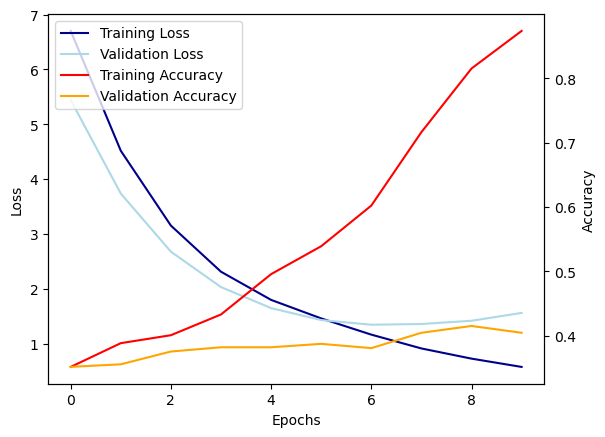

In [22]:
import matplotlib.pyplot as plt

# Get the training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss', color='darkblue')
plt.plot(val_loss, label='Validation Loss', color='lightblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot the training and validation accuracy curves
plt.twinx()  # Create a second y-axis that shares the same x-axis
plt.plot(train_acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.ylabel('Accuracy')

handles, labels = [], []
for ax in plt.gcf().axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles, labels)

plt.show()